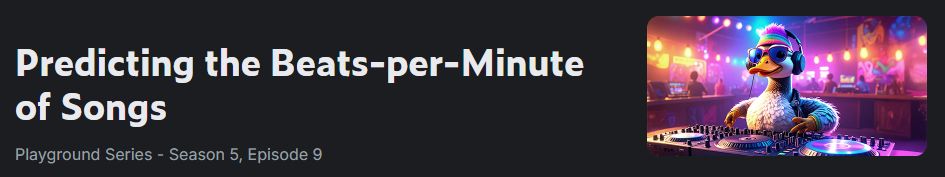
* https://www.kaggle.com/competitions/playground-series-s5e9
* 위 공모전의 목표: 주어진 노래의 여러 특징(feature)들을 기반으로 해당 곡의 BPM(박자 수) 을 예측하는 것

In [3]:
# 파이썬 기본 라이브러리
import math
import warnings

# 데이터 분석 및 시각화 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 주피터 노트북 환경 설정용
from IPython.display import display, HTML

# Scikit-learn (머신러닝) 라이브러리
import sklearn

# 데이터 분할 및 교차 검증
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    GridSearchCV,
)

# 회귀 모델 (선형, 트리, 앙상블, SVM)
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR

# 데이터 전처리 및 특성 공학 (스케일러, 변환)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer,
)

# 파이프라인 및 특성 선택
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# 타깃 변수 변환
from sklearn.compose import TransformedTargetRegressor

# 모델 평가 지표
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)

# 부스팅 계열 모델 (XGBoost, LightGBM, ...)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# 실행 환경 설정: 경고 메시지 무시
warnings.filterwarnings(action='ignore')

# 시각화 기본 스타일 설정 (Seaborn)
sns.set()

# 시각화 한글 폰트 및 마이너스 부호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 주피터 노트북 셀 너비 확장
display(HTML("<style>.container{width:100% !important;}</style>"))

# Pandas 데이터프레임 출력 옵션 설정
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# Data Load

In [4]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


# EDA

| 약어 (Abbr.) | 전체 이름 (Full Name)           | 한 줄 요약 설명 |
|:-------------:|:--------------------------------:|:----------------|
| <font color=yellow>---</font> | <font color=yellow>기본 피쳐</font> | <font color=yellow>---</font> |
| **rs**  | RhythmScore | 리듬의 복잡성이나 규칙성을 나타내는 점수 |
| **al**  | AudioLoudness | 노래의 전체적인 평균 음량 (데시벨) |
| **vc**  | VocalContent | 노래에서 보컬(목소리)이 차지하는 비중 |
| **aq**  | AcousticQuality | 음악이 얼마나 '어쿠스틱'한지(전자음이 적은지) 나타내는 척도 |
| **is**  | InstrumentalScore | 노래에서 악기 연주가 차지하는 비중 |
| **lpl** | LivePerformanceLikelihood | 이 곡이 라이브 공연일 가능성 |
| **ms**  | MoodScore | 곡의 전반적인 분위기(예: 긍정, 부정)를 나타내는 점수 |
| **tdm** | TrackDurationMs | 노래의 총 길이 (밀리초 단위) |
| **e**   | Energy | 노래의 에너지 레벨, 즉 강렬하고 활기찬 정도 |
| **bpm** | BeatsPerMinute | (타겟 변수) 1분당 비트 수, 즉 노래의 빠르기 |
| <font color=yellow>---</font> | <font color=yellow>파생 피쳐</font> | <font color=yellow>---</font> |
| **tdm** | TrackDurationMin | tdm(밀리초)을 분(minute) 단위로 변환한 노래의 길이 |
| **ear** | Energy_Acoustic_Ratio | 에너지 대비 어쿠스틱함의 비율로, 전자음악/어쿠스틱 성향을 나타냄 |
| **vib** | Vocal_Instrument_Balance | 보컬과 악기 사운드의 균형을 나타내는 지표 |
| **mr**  | MoodRhythm | 분위기(Mood)와 리듬감(Rhythm)의 시너지 효과를 나타내는 점수 |
| **pi**  | PerformanceIntensity | 라이브 공연의 강렬함 또는 현장감을 나타내는 지표 |
| **re**  | RhythmEnergy | 리듬의 활기 또는 댄스 가능성을 나타내는 에너지 점수 |
| **ma**  | MoodAcoustic | 음악의 분위기와 어쿠스틱 특성의 조합을 나타내는 값 |

* 학습에 필요없는 id 컬럼 드랍
* 컬럼명 변경

In [5]:
df = df.drop('id', axis=1)
df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
df.head()

,rs,al,vc,aq,is,lpl,ms,tdm,e,bpm
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


* 결측 없고 다 수치형

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rs      524164 non-null  float64
 1   al      524164 non-null  float64
 2   vc      524164 non-null  float64
 3   aq      524164 non-null  float64
 4   is      524164 non-null  float64
 5   lpl     524164 non-null  float64
 6   ms      524164 non-null  float64
 7   tdm     524164 non-null  float64
 8   e       524164 non-null  float64
 9   bpm     524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB


* 히스토그램
* 오른쪽으로 치우치고(왜도 > 0) 매우 뾰족한(첨도 > 3) 분포: vc, aq, is, lpl
* 왼쪽으로 살짝 치우친(왜도 < 0) 분포: al
* ms의 중간값이 비어 보이는 건 음악의 분위기가 어중간하기보다 확실히 밝거나 확실히 어둡다는 특성을 보여주는 결과
* ms는 데이터에 오류가 있다기보다는, 음악 자체가 가진 본질적인 특성일 가능성이 매우 높음

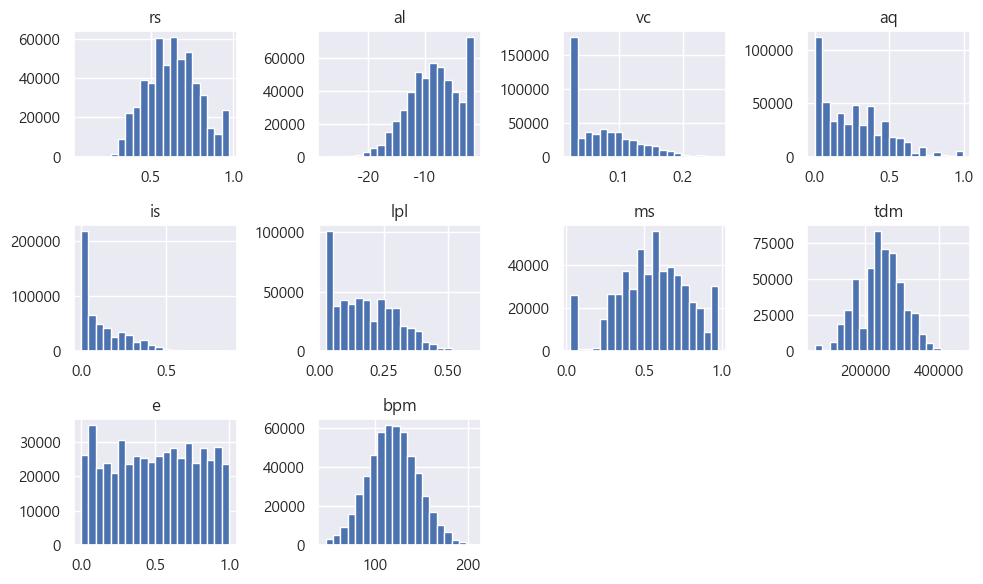

In [7]:
df.hist(figsize=(10, 6), bins=20, layout=(3, 4))
plt.tight_layout()
plt.show()

* 오른쪽으로 심하게 치우친 변수들 (vc, aq, is, lpl, tdm)
* 이 피쳐들은 대부분의 값이 낮은 쪽에 몰려있고, 아웃라이어가 많이 존재
* 왼쪽으로 치우친 변수들 (rs, al, tdm)
* 이 피쳐들은 반대로 대부분의 값이 높은 쪽에 몰려있고, 아웃라이어가 일부 존재

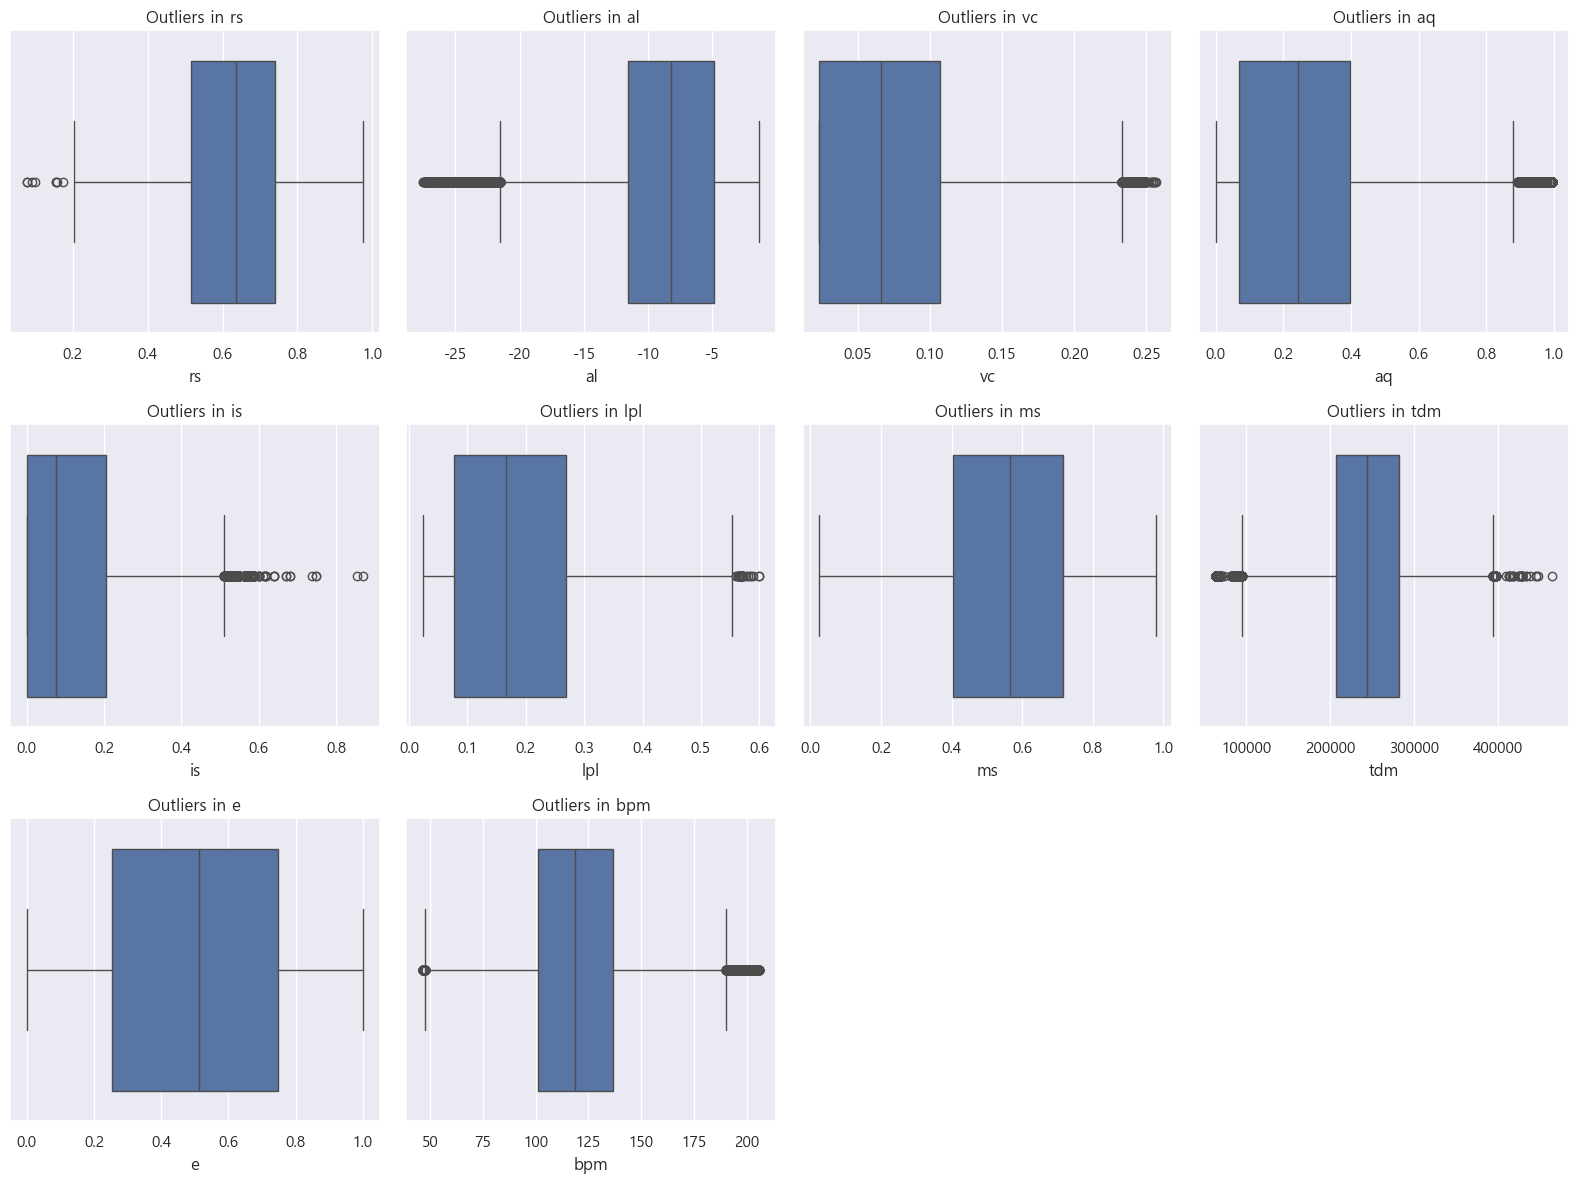

In [8]:
# 3x4 격자 형태의 서브플롯(그래프 틀) 생성
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten() # 2차원 배열의 axes를 1차원으로 변환하여 다루기 쉽게 함

# 데이터프레임의 각 열(column)에 대해 반복하여 박스 플롯(boxplot) 생성
for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 데이터프레임의 열 개수보다 서브플롯 개수가 많을 경우, 남는 플롯은 숨김 처리
for j in range(len(df.columns), len(axes)):
    axes[j].axis('off')

# 플롯 간 간격을 자동으로 조절하여 겹치지 않게 함
plt.tight_layout()

# 최종 그래프 출력
plt.show()

* ㅁㄴㅇㄹ

In [9]:
dforg = df.copy()

# 공통함수

# 공통함수 myscore (dforg)

In [10]:
best_scores = None
prev_best_scores = None  # 직전 best 저장

def myscore(X80=None, y80=None, X20=None, y20=None, model=None, df=None, fi=None, top_n=None):
    global best_scores, prev_best_scores
    precision = 5

    # ---------------- 데이터 준비 ----------------
    if df is not None:
        y = df['bpm']
        X = df.drop('bpm', axis=1)
        X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)
    
    if model is None:
        model = XGBRegressor(random_state=8989)
    
    # ---------------- 학습 및 예측 ----------------
    model.fit(X80, y80)
    pred = model.predict(X20)

    # ---------------- RMSE 계산 ----------------
    rmse = round(np.sqrt(mean_squared_error(y20, pred)), precision)

    print(f"\nMODEL : {model.__class__.__name__}")

    # ---------------- 최고 점수 관리 ----------------
    if best_scores is None:
        best_scores = {'RMSE': rmse}
        prev_best_scores = {'RMSE': rmse}
    else:
        prev_best_scores = best_scores.copy()
        if rmse < best_scores['RMSE']:
            best_scores['RMSE'] = rmse

    # ---------------- 결과 비교 출력 ----------------
    prev_val = prev_best_scores['RMSE']
    best_val = best_scores['RMSE']

    # 화살표 방향 (현재 vs Prev Best)
    if rmse == prev_val:
        arrow = "➡️"
    elif rmse < prev_val:
        arrow = "⬆️"
    else:
        arrow = "⬇️"

    print(f"RMSE : {rmse:.5f} (Prev Best: {prev_val:.5f} | Now Best: {best_val:.5f}) {arrow}\n")
    print("-----------------------------------------------------------------------\n")

    # ---------------- Feature Importance 시각화 ----------------
    if fi:
        if isinstance(model, Pipeline):
            actual_model = model.steps[-1][1]
        else:
            actual_model = model
        
        if not hasattr(actual_model, 'feature_importances_'):
            print(f"\nNOTE: 이 모델({actual_model.__class__.__name__})은 feature_importances_ 속성이 없습니다.")
            return
            
        importances = actual_model.feature_importances_
        feature_names = X80.columns
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi_df = fi_df.sort_values(by='importance', ascending=False)
        
        title_text = f'Feature Importances ({actual_model.__class__.__name__})'
        if top_n is not None:
            fi_df = fi_df.head(top_n)
            title_text = f'Top {top_n} ' + title_text
            
        plt.figure(figsize=(12, 6))
        sns.barplot(x='feature', y='importance', data=fi_df)
        plt.title(title_text)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 1st Validation Score

In [11]:
model_list = [
    XGBRegressor(random_state=8989),
    LGBMRegressor(random_state=8989, verbosity=-1)
]

for model in model_list:
    myscore(df = df, model = model)


MODEL : XGBRegressor
RMSE : 26.51690 (Prev Best: 26.51690 | Now Best: 26.51690) ➡️

-----------------------------------------------------------------------


MODEL : LGBMRegressor
RMSE : 26.42507 (Prev Best: 26.51690 | Now Best: 26.42507) ⬆️

-----------------------------------------------------------------------



## 1st Kaggle Score

In [12]:
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

y80 = dforg['bpm']
X80 = dforg.drop('bpm', axis=1)

final_model = XGBRegressor(random_state=8989)

final_model.fit(X80, y80)
predictions = final_model.predict(test_df)

submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission.head())


✅ submission.csv 파일 생성 완료!
제출 파일 미리보기:
       id         bpm
0  524164  118.636620
1  524165  115.162727
2  524166  121.749283
3  524167  119.649025
4  524168  122.281967


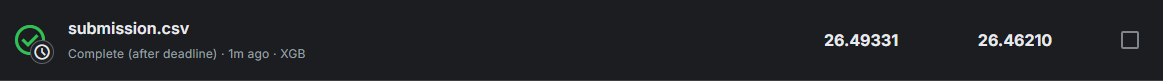

In [13]:
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

y80 = dforg['bpm']
X80 = dforg.drop('bpm', axis=1)

final_model = LGBMRegressor(random_state=8989, verbosity=-1)

final_model.fit(X80, y80)
predictions = final_model.predict(test_df)

submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission.head())


✅ submission.csv 파일 생성 완료!
제출 파일 미리보기:
       id         bpm
0  524164  120.388017
1  524165  118.155152
2  524166  119.354544
3  524167  118.512041
4  524168  119.671626


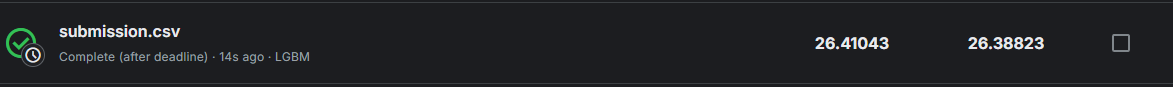

# 전처리 & 가공

## 이상치 제거 (dforg -> dft)

In [14]:
# 원본 데이터프레임을 복사하여 Trimming용 데이터프레임 'dft' 생성
dft = dforg.copy()

# 숫자형 특성(column)만 선택하여 리스트로 저장
num_features_for_trim = dft.select_dtypes(include=np.number).columns.tolist()

# Trimming 작업 시작 및 원본 데이터 형태(shape) 출력
print(">> Trimming Process Start")
print("Original Shape (dft):", dft.shape)

# 각 숫자형 특성에 대해 반복하여 이상치 제거 수행
for col in num_features_for_trim:
    # 사분위수(Q1, Q3) 및 사분위 범위(IQR) 계산
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # IQR을 이용해 이상치 경계값(lower/upper bound) 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 경계값을 벗어나는 행(row)을 데이터프레임에서 제거
    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

# Trimming 완료 후 데이터 형태(shape) 출력
print("Trimmed Shape (dft):", dft.shape)

>> Trimming Process Start
Original Shape (dft): (524164, 10)
Trimmed Shape (dft): (505206, 10)


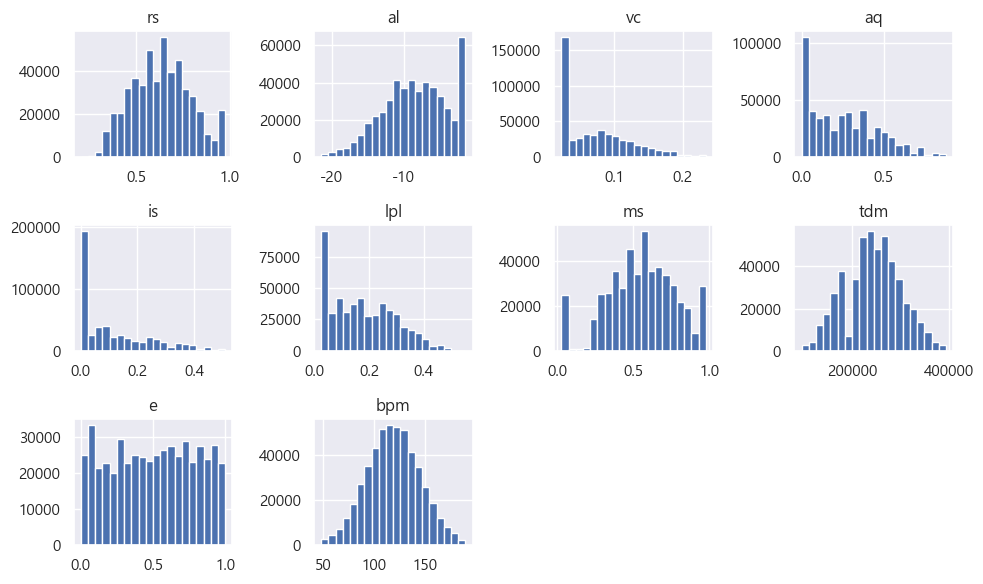

In [15]:
dft.hist(figsize=(10, 6), bins=20, layout=(3, 4))
plt.tight_layout()
plt.show()

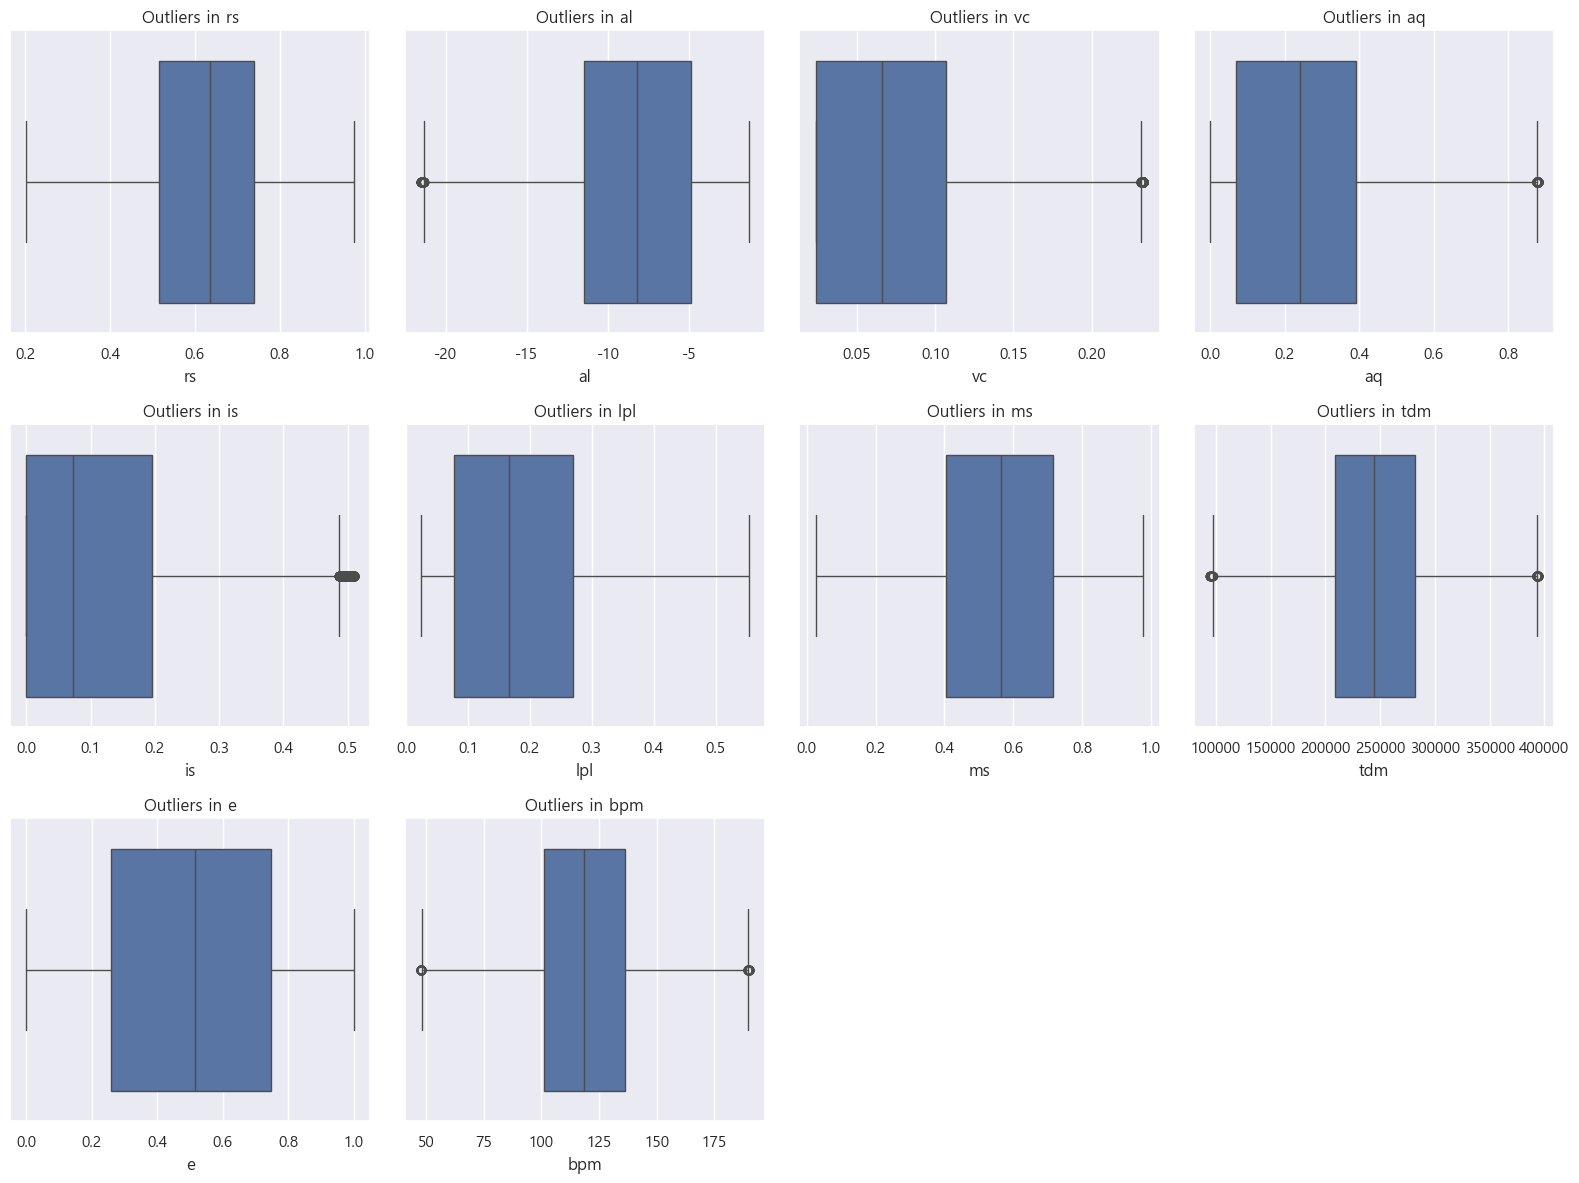

In [16]:
# 3x4 격자 형태의 서브플롯(그래프 틀) 생성
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten() # 2차원 배열의 axes를 1차원으로 변환하여 다루기 쉽게 함

# 데이터프레임의 각 열(column)에 대해 반복하여 박스 플롯(boxplot) 생성
for i, col in enumerate(dft.columns):
    sns.boxplot(x=dft[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 데이터프레임의 열 개수보다 서브플롯 개수가 많을 경우, 남는 플롯은 숨김 처리
for j in range(len(dft.columns), len(axes)):
    axes[j].axis('off')

# 플롯 간 간격을 자동으로 조절하여 겹치지 않게 함
plt.tight_layout()

# 최종 그래프 출력
plt.show()

### 2nd Validation Score

In [17]:
myscore(df = dft)


MODEL : XGBRegressor
RMSE : 26.13966 (Prev Best: 26.42507 | Now Best: 26.13966) ⬆️

-----------------------------------------------------------------------



### 2nd Kaggle Score

In [18]:
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

dft = dforg.copy()
num_features_for_trim = dft.select_dtypes(include=np.number).columns.tolist()

for col in num_features_for_trim:
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

y80 = dft['bpm']
X80 = dft.drop('bpm', axis=1)

final_model = LGBMRegressor(random_state=8989, verbosity=-1)

final_model.fit(X80, y80)
predictions = final_model.predict(test_df)

submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission.head())


✅ submission.csv 파일 생성 완료!
제출 파일 미리보기:
       id         bpm
0  524164  118.794650
1  524165  118.677460
2  524166  120.283635
3  524167  119.235174
4  524168  119.964804


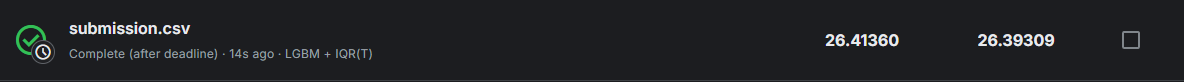

## 이상치 대체 (dforg -> dfw)

In [19]:
# 원본 데이터프레임을 복사하여 Winsorization용 데이터프레임 'dfw' 생성
dfw = dforg.copy()

# 숫자형 특성(column)만 선택하여 리스트로 저장
num_features_for_winsorize = dfw.select_dtypes(include=np.number).columns.tolist()

# Winsorization 작업 시작 및 원본 데이터 형태(shape) 출력
print(">> Winsorization Process Start")
print("Original Shape (dfw):", dfw.shape)

# 각 숫자형 특성에 대해 반복하여 이상치 대체 수행
for col in num_features_for_winsorize:
    # 사분위수(Q1, Q3) 및 사분위 범위(IQR) 계산
    Q1 = dfw[col].quantile(0.25)
    Q3 = dfw[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # IQR을 이용해 이상치 경계값(lower/upper bound) 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 경계값을 벗어나는 값을 해당 경계값으로 대체
    dfw[col] = np.where(dfw[col] < lower_bound, lower_bound,
                        np.where(dfw[col] > upper_bound, upper_bound, dfw[col]))

# Winsorization 완료 후 데이터 형태(shape) 출력 (행의 수는 변하지 않음)
print("Winsorized Shape (dfw):", dfw.shape)

>> Winsorization Process Start
Original Shape (dfw): (524164, 10)
Winsorized Shape (dfw): (524164, 10)


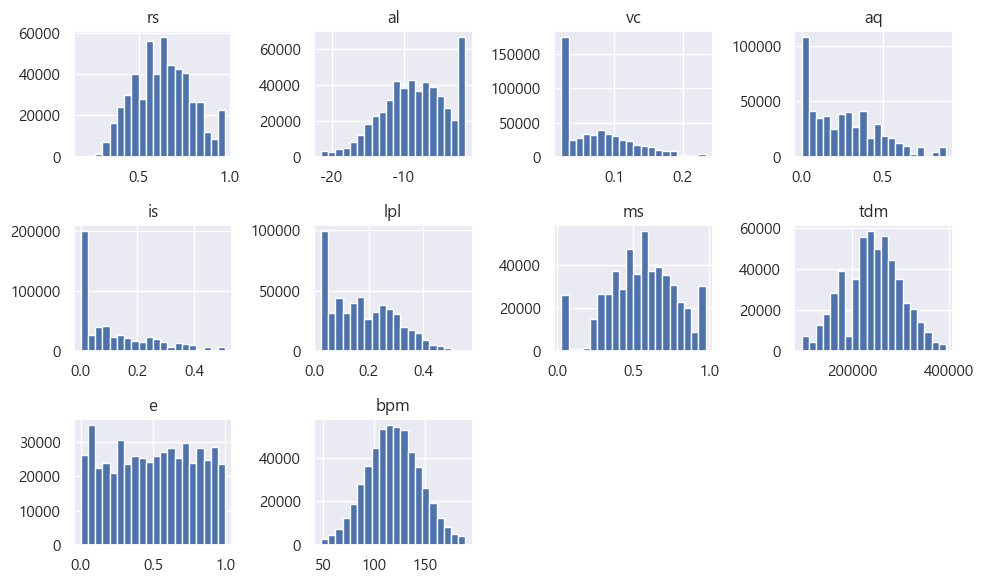

In [20]:
dfw.hist(figsize=(10, 6), bins=20, layout=(3, 4))
plt.tight_layout()
plt.show()

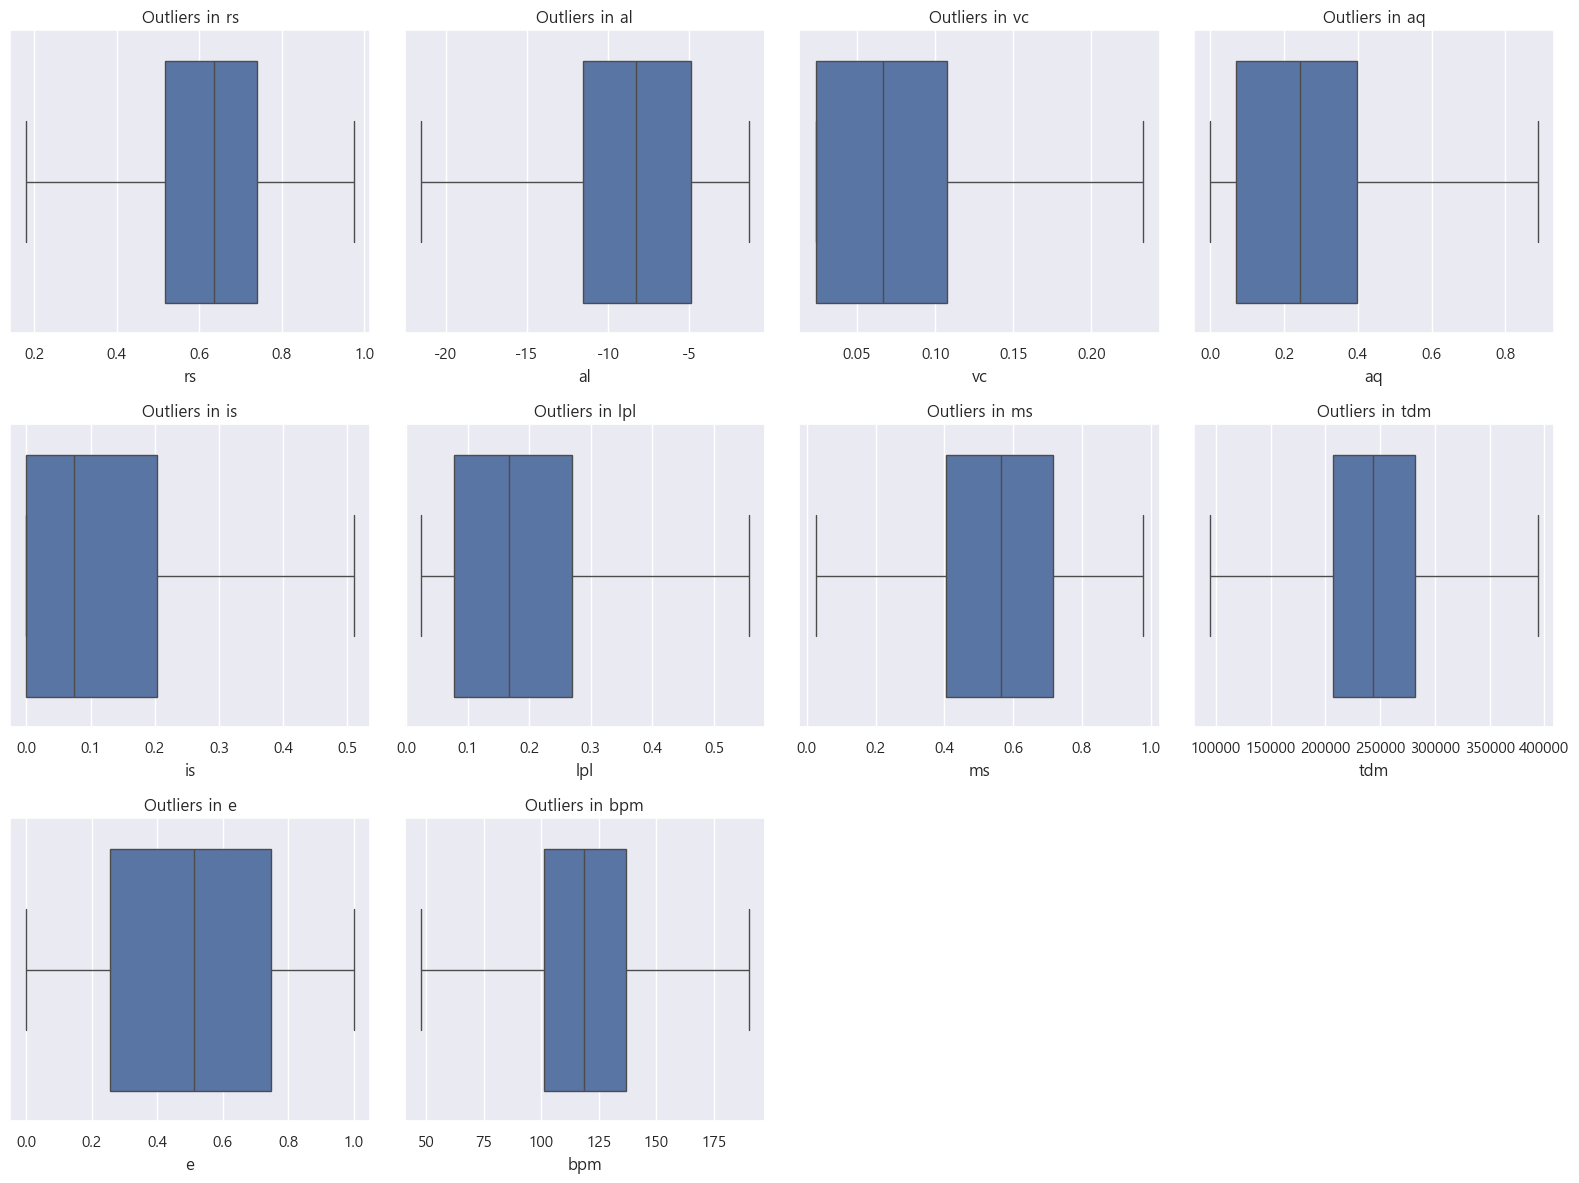

In [21]:
# 3x4 격자 형태의 서브플롯(그래프 틀) 생성
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten() # 2차원 배열의 axes를 1차원으로 변환하여 다루기 쉽게 함

# 데이터프레임의 각 열(column)에 대해 반복하여 박스 플롯(boxplot) 생성
for i, col in enumerate(dfw.columns):
    sns.boxplot(x=dfw[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 데이터프레임의 열 개수보다 서브플롯 개수가 많을 경우, 남는 플롯은 숨김 처리
for j in range(len(dfw.columns), len(axes)):
    axes[j].axis('off')

# 플롯 간 간격을 자동으로 조절하여 겹치지 않게 함
plt.tight_layout()

# 최종 그래프 출력
plt.show()

### 3rd Validation Score

In [22]:
myscore(df = dfw)


MODEL : XGBRegressor
RMSE : 26.46275 (Prev Best: 26.13966 | Now Best: 26.13966) ⬇️

-----------------------------------------------------------------------



### 3rd Kaggle Score

In [23]:
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

dfw = dforg.copy()
num_features_for_winsorize = dfw.select_dtypes(include=np.number).columns.tolist()

for col in num_features_for_winsorize:
    Q1 = dfw[col].quantile(0.25)
    Q3 = dfw[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    dfw[col] = np.where(dfw[col] < lower_bound, lower_bound,
                        np.where(dfw[col] > upper_bound, upper_bound, dfw[col]))

y80 = dfw['bpm']
X80 = dfw.drop('bpm', axis=1)

final_model = LGBMRegressor(random_state=8989, verbosity=-1)

final_model.fit(X80, y80)
predictions = final_model.predict(test_df)

submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission.head())


✅ submission.csv 파일 생성 완료!
제출 파일 미리보기:
       id         bpm
0  524164  118.907743
1  524165  118.431576
2  524166  119.614066
3  524167  119.427302
4  524168  119.716571


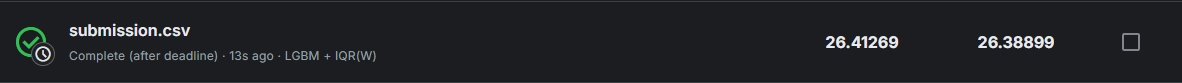

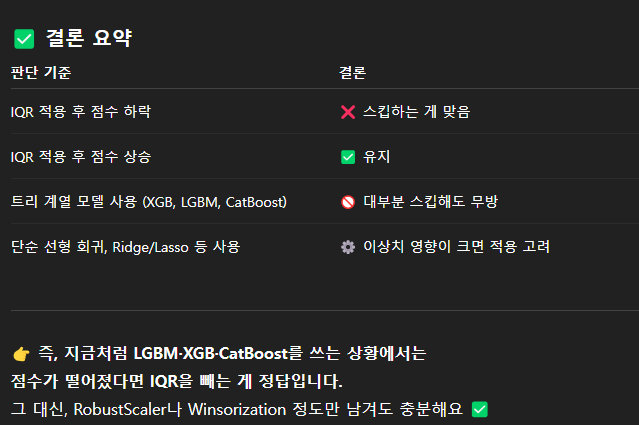

## 파생 피쳐 추가 (dforg -> dfaef)

In [24]:
# --- df 복사본 생성 ---
dfaef = dforg.copy()

# --- Feature Engineering (파생 변수 생성) ---

# TrackDurationMin | tdm(밀리초)을 분(minute) 단위로 변환한 노래의 길이
dfaef['tdn'] = dfaef['tdm'] / 60000

# Energy_Acoustic_Ratio | 에너지 대비 어쿠스틱함의 비율로, 전자음악/어쿠스틱 성향을 나타냄
dfaef['ear'] = dfaef['e'] / (dfaef['aq'] + 1e-5)

# Vocal_Instrument_Balance | 보컬과 악기 사운드의 균형을 나타내는 지표
dfaef['vib'] = dfaef['vc'] / (dfaef['is'] + 1e-5)

# MoodRhythm | 분위기(Mood)와 리듬감(Rhythm)의 시너지 효과를 나타내는 점수
dfaef['mr'] = dfaef['ms'] * dfaef['rs']

# PerformanceIntensity | 라이브 공연의 강렬함 또는 현장감을 나타내는 지표
dfaef['pi'] = dfaef['lpl'] * dfaef['al']

# RhythmEnergy | 리듬의 활기 또는 댄스 가능성을 나타내는 에너지 점수
dfaef['re'] = dfaef['rs'] * dfaef['e']

# MoodAcoustic | 음악의 분위기와 어쿠스틱 특성의 조합을 나타내는 값
dfaef['ma'] = dfaef['ms'] * dfaef['aq']

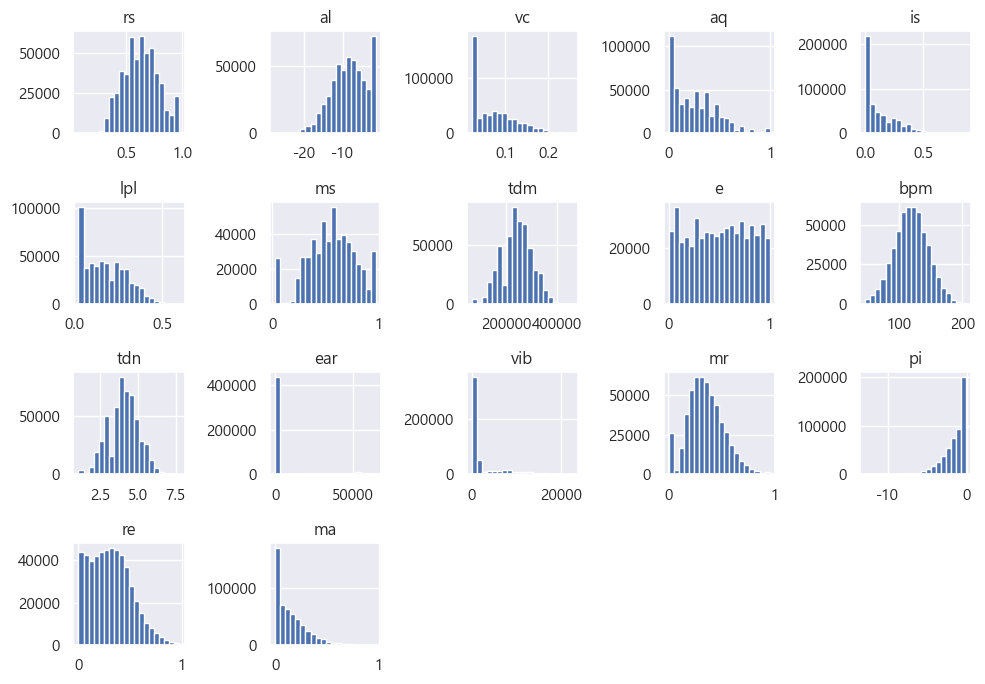

In [25]:
dfaef.hist(figsize=(10, 7), bins=20, layout=(4, 5))
plt.tight_layout()
plt.show()

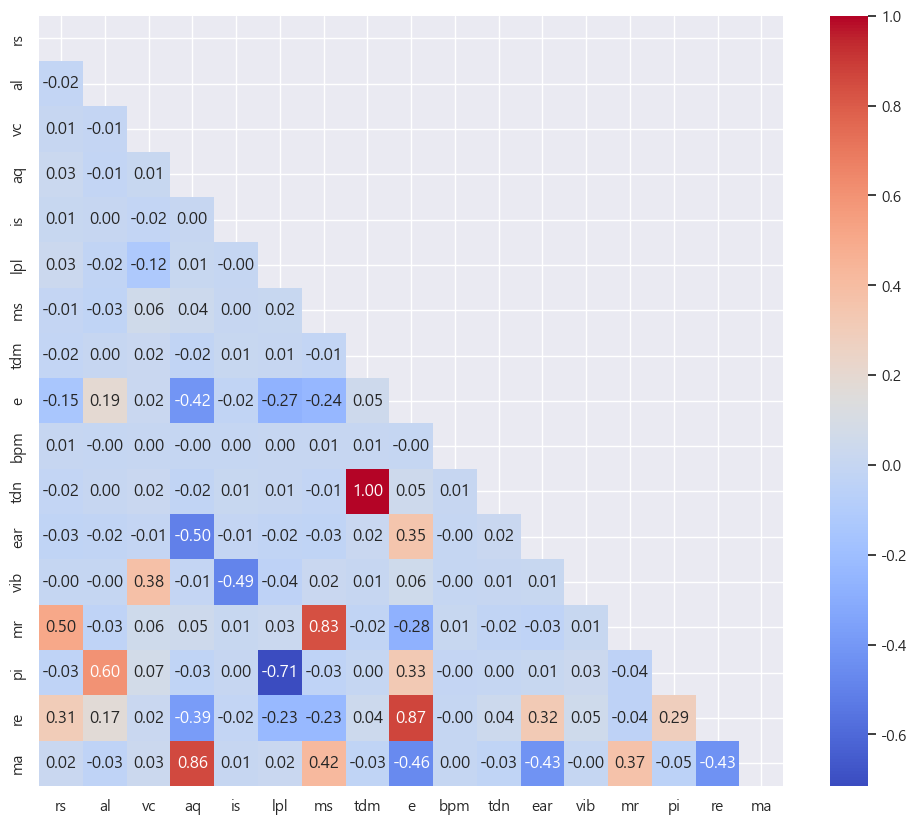

In [26]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(dfaef.corr(), dtype=bool))
sns.heatmap(dfaef.corr(), annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.show()

### 4th Validation Score

In [27]:
myscore(df = dfaef)


MODEL : XGBRegressor
RMSE : 26.51842 (Prev Best: 26.13966 | Now Best: 26.13966) ⬇️

-----------------------------------------------------------------------



### 4th Kaggle Score

In [28]:
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

dfaef = dforg.copy()

dfaef['tdn'] = dfaef['tdm'] / 60000
test_df['tdn'] = test_df['tdm'] / 60000

dfaef['ear'] = dfaef['e'] / (dfaef['aq'] + 1e-5)
test_df['ear'] = test_df['e'] / (test_df['aq'] + 1e-5)

dfaef['vib'] = dfaef['vc'] / (dfaef['is'] + 1e-5)
test_df['vib'] = test_df['vc'] / (test_df['is'] + 1e-5)

dfaef['mr'] = dfaef['ms'] * dfaef['rs']
test_df['mr'] = test_df['ms'] * test_df['rs']

dfaef['pi'] = dfaef['lpl'] * dfaef['al']
test_df['pi'] = test_df['lpl'] * test_df['al']

dfaef['re'] = dfaef['rs'] * dfaef['e']
test_df['re'] = test_df['rs'] * test_df['e']

dfaef['ma'] = dfaef['ms'] * dfaef['aq']
test_df['ma'] = test_df['ms'] * test_df['aq']

X80 = dfaef.drop('bpm', axis=1)
y80 = dfaef['bpm']

final_model = XGBRegressor(random_state=8989)

final_model.fit(X80, y80)
predictions = final_model.predict(test_df)

submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission.head())


✅ submission.csv 파일 생성 완료!
제출 파일 미리보기:
       id         bpm
0  524164  119.277084
1  524165  117.547470
2  524166  118.079384
3  524167  121.794609
4  524168  121.164337


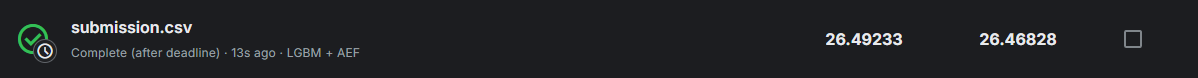

## 피쳐 셀렉션

### 파생 피쳐 O (dfaef -> dffs)

In [29]:
# 1. df 복사본 생성
dffs = dfaef.copy()

# 2. 타깃과 피처 분리
y = dffs['bpm']
X = dffs.drop('bpm', axis=1)

# 3. Ridge 기반 Feature Selection
selector = SelectFromModel(
    estimator=Ridge(alpha=1.0),
    threshold='median'   # 중요도가 중앙값 이상인 피처만 선택
)

selector.fit(X, y)

# 4. 선택된 피처 이름 확인
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

print(f"총 {len(X.columns)}개 중 {len(selected_features)}개 피처 선택됨")
print("\n[선택된 피처 목록]")
print(list(selected_features))

# 5. 선택된 피처로 dffs 갱신 (bpm 포함)
dffs = dffs[['bpm'] + list(selected_features)]

print(f"\n갱신된 dffs 형태: {dffs.shape}")

총 16개 중 8개 피처 선택됨

[선택된 피처 목록]
['rs', 'vc', 'aq', 'lpl', 'ms', 'e', 'mr', 're']

갱신된 dffs 형태: (524164, 9)


#### 5th Validation Score

In [30]:
myscore(df = dffs)


MODEL : XGBRegressor
RMSE : 26.51517 (Prev Best: 26.13966 | Now Best: 26.13966) ⬇️

-----------------------------------------------------------------------



#### 5th Kaggle Score

In [31]:
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

dfaef = dforg.copy()

dfaef['tdn'] = dfaef['tdm'] / 60000
test_df['tdn'] = test_df['tdm'] / 60000

dfaef['ear'] = dfaef['e'] / (dfaef['aq'] + 1e-5)
test_df['ear'] = test_df['e'] / (test_df['aq'] + 1e-5)

dfaef['vib'] = dfaef['vc'] / (dfaef['is'] + 1e-5)
test_df['vib'] = test_df['vc'] / (test_df['is'] + 1e-5)

dfaef['mr'] = dfaef['ms'] * dfaef['rs']
test_df['mr'] = test_df['ms'] * test_df['rs']

dfaef['pi'] = dfaef['lpl'] * dfaef['al']
test_df['pi'] = test_df['lpl'] * test_df['al']

dfaef['re'] = dfaef['rs'] * dfaef['e']
test_df['re'] = test_df['rs'] * test_df['e']

dfaef['ma'] = dfaef['ms'] * dfaef['aq']
test_df['ma'] = test_df['ms'] * test_df['aq']

dffs = dfaef.copy()
y = dffs['bpm']
X = dffs.drop('bpm', axis=1)

selector = SelectFromModel(
    estimator=Ridge(alpha=1.0),
    threshold='median'
)
selector.fit(X, y)

selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

dffs = dffs[['bpm'] + list(selected_features)]
test_df = test_df[selected_features]

X80 = dffs.drop('bpm', axis=1)
y80 = dffs['bpm']

final_model = XGBRegressor(random_state=8989)

final_model.fit(X80, y80)
predictions = final_model.predict(test_df)

submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission.head())


✅ submission.csv 파일 생성 완료!
제출 파일 미리보기:
       id         bpm
0  524164  118.250626
1  524165  119.091660
2  524166  117.865883
3  524167  118.350723
4  524168  120.370033


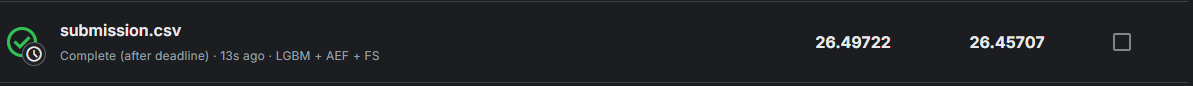

### 파생 피쳐 X (dforg -> dffs)

In [32]:
# 1. df 복사본 생성
dffs = dforg.copy()

# 2. 타깃과 피처 분리
y = dffs['bpm']
X = dffs.drop('bpm', axis=1)

# 3. Ridge 기반 Feature Selection
selector = SelectFromModel(
    estimator=Ridge(alpha=1.0),
    threshold='median'   # 중요도가 중앙값 이상인 피처만 선택
)

selector.fit(X, y)

# 4. 선택된 피처 이름 확인
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

print(f"총 {len(X.columns)}개 중 {len(selected_features)}개 피처 선택됨")
print("\n[선택된 피처 목록]")
print(list(selected_features))

# 5. 선택된 피처로 dffs 갱신 (bpm 포함)
dffs = dffs[['bpm'] + list(selected_features)]

print(f"\n갱신된 dffs 형태: {dffs.shape}")

총 9개 중 5개 피처 선택됨

[선택된 피처 목록]
['rs', 'vc', 'is', 'lpl', 'ms']

갱신된 dffs 형태: (524164, 6)


#### 6th Validation Score

In [33]:
myscore(df = dffs)


MODEL : XGBRegressor
RMSE : 26.51775 (Prev Best: 26.13966 | Now Best: 26.13966) ⬇️

-----------------------------------------------------------------------



#### 6th Kaggle Score

In [34]:
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

dffs = dforg.copy()
y = dffs['bpm']
X = dffs.drop('bpm', axis=1)

selector = SelectFromModel(
    estimator=Ridge(alpha=1.0),
    threshold='median'
)
selector.fit(X, y)

selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

dffs = dffs[['bpm'] + list(selected_features)]
test_df = test_df[selected_features]

X80 = dffs.drop('bpm', axis=1)
y80 = dffs['bpm']

final_model = XGBRegressor(random_state=8989)

final_model.fit(X80, y80)
predictions = final_model.predict(test_df)

submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("\n✅ submission.csv 파일 생성 완료!")
print("제출 파일 미리보기:")
print(submission.head())


✅ submission.csv 파일 생성 완료!
제출 파일 미리보기:
       id         bpm
0  524164  117.297859
1  524165  120.751114
2  524166  119.113693
3  524167  119.499367
4  524168  120.752602
